## This is an example of how to use K-Means Clustering Method for Cluster Analysis of quantitative data, using Python, Pandas, NumPy, SciPy, Scikit-learn, Pingouin, Matplotlib, Seaborn and Plotly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import pingouin as pg
import plotly.express as px
import os
import plotly.io as pio
if os.getenv("GITHUB_ACTIONS") == "true":
    pio.renderers.default = "png"
else:
    pio.renderers.default='colab'

- the formulas shown at this notebook have been taken from the following reference:

    FÁVERO, L. P.; BELFIORE, P. Manual de Análise de Dados: Estatística e Machine Learning com Excel®, SPSS®, Stata®, R® e Python®. 2ª edição, 1288 p. Brasil: ccGEN LTC, 2024.
    
    Available in Brazil at:
    
    https://www.amazon.com.br/Manual-An-C3-A1lise-Dados-Estat-C3-ADstica-Learning-dp-8595159920/dp/8595159920

## Use Case Scenario and Data - Student Disciplines' Grades

In this sample use case, we have some students' grades for 3 disciplines (features). We wanna segment (clusterize) students according to unknown patterns, based on such grades, in order that each student category can be tackled efficiently and grades can be improved with individualized interventions for each student category (cluster).

In [2]:
# reading and displaying our dataset
entrance_exam_data = pd.read_excel("entrance_exam.xlsx")
entrance_exam_data_without_student = entrance_exam_data.drop(columns=["STUDENT"])
entrance_exam_data_without_student

,MATH,PHYSICS,CHEMISTRY
0,3.7,2.7,9.1
1,7.8,8.0,1.5
2,8.9,1.0,2.7
3,7.0,1.0,9.0
4,3.4,2.0,5.0


Ps.: initial data descriptives and 3D visualization have been demonstrated already at the .ipynb below (equivalent to this one), and, as then, no normalization of data is necessary here as well - the dataset is the same. Here, we start by directly implementing the clustering process itself, using K-Means instead of the Hierarchical Aggregative method. For data descriptives and graphical visualization, and for the demonstration of the Hierarchical Aggregative method, please see the other .ipynb, available at:<br>
[sample-ml-clustering-hierarchical-agglomerative-student.ipynb](./sample-ml-clustering-hierarchical-agglomerative-student.ipynb)

## K-Means Clustering Method

In [3]:
# proceeding the clustering, using K-Means method and considering that we have defined that 3 clusters should be the output - and 
# we want the algorithm to allocate the right elements inside them:
kmeans = KMeans(n_clusters=3, init='random', random_state=100).fit(entrance_exam_data_without_student)

# extracting the generated labels from the final kmeans clustering result and setting that as a new category variable at the 
# original dataframe for describing which cluster each observation belongs to, after the clustering has been concluded. Here we 
# have cluster 0 (with student C), cluster 1 (with student B) and cluster 2 (with students A, D and E).
kmeans_clusters_labels = kmeans.labels_
entrance_exam_data['CLUSTER_INDICATOR_KMEANS']=kmeans_clusters_labels
entrance_exam_data['CLUSTER_INDICATOR_KMEANS']=entrance_exam_data['CLUSTER_INDICATOR_KMEANS'].astype('category')
entrance_exam_data

,STUDENT,MATH,PHYSICS,CHEMISTRY,CLUSTER_INDICATOR_KMEANS
0,Student_A,3.7,2.7,9.1,2
1,Student_B,7.8,8.0,1.5,1
2,Student_C,8.9,1.0,2.7,0
3,Student_D,7.0,1.0,9.0,2
4,Student_E,3.4,2.0,5.0,2


In [4]:
# extracting the final centroids' coordinates for the final kmeans clusters
# all three variables' values are the 3D coordinates for each cluster below
kmeans_clusters_centroids = pd.DataFrame(kmeans.cluster_centers_)
kmeans_clusters_centroids.columns=entrance_exam_data_without_student.columns
kmeans_clusters_centroids['CLUSTER_INDICATOR_KMEANS']='Cluster_'+kmeans_clusters_centroids.index.astype(str)
kmeans_clusters_centroids

,MATH,PHYSICS,CHEMISTRY,CLUSTER_INDICATOR_KMEANS
0,8.9,1.0,2.7,Cluster_0
1,7.8,8.0,1.5,Cluster_1
2,4.7,1.9,7.7,Cluster_2


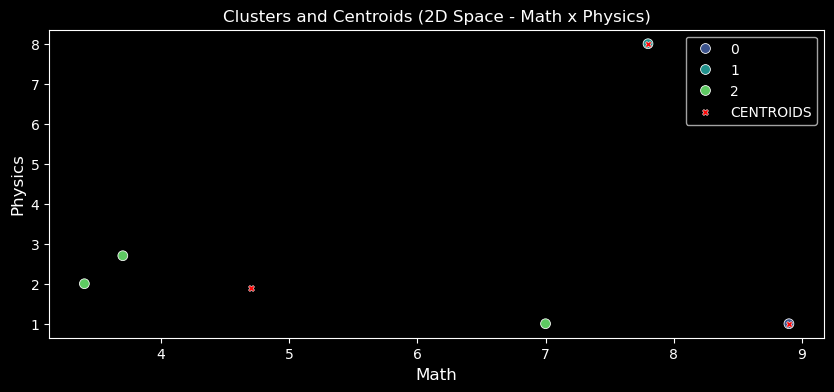

In [5]:
# plotting observations (purple, blue and green) along with clusters' centroids (red) after convergence (final output)... other 
# 2D graph planes (of the actual 3D graph) could be plotted for the same observations and centroids. Here, we're plotting the 
# plane where x=Math and y=Physics
plt.figure(figsize=(10,4))
sns.scatterplot(data=entrance_exam_data, x='MATH', y='PHYSICS', hue='CLUSTER_INDICATOR_KMEANS', palette='viridis', s=50)
sns.scatterplot(data=kmeans_clusters_centroids, x='MATH', y='PHYSICS', c='red', label='CENTROIDS', marker="X", s=20)
plt.title('Clusters and Centroids (2D Space - Math x Physics)', fontsize=12)
plt.xlabel('Math', fontsize=12)
plt.ylabel('Physics', fontsize=12)
plt.legend()
plt.show()

In [6]:
# we can plot and see the observations and centroids better using a 3D graph, as below:

import plotly.graph_objects as go
fig = go.Figure()

# ---------- 1. Centroids scatter ----------
fig.add_trace(go.Scatter3d(
    x=kmeans_clusters_centroids["MATH"],
    y=kmeans_clusters_centroids["CHEMISTRY"],
    z=kmeans_clusters_centroids["PHYSICS"],
    mode='markers+text',
    text=kmeans_clusters_centroids["CLUSTER_INDICATOR_KMEANS"],
    textposition='bottom center',
    textfont=dict(size=10),
    name="Centroids",
    marker=dict(size=8, color="red", symbol="diamond")
))

# ---------- 2. Students scatter ----------
fig.add_trace(go.Scatter3d(
    x=entrance_exam_data["MATH"],
    y=entrance_exam_data["CHEMISTRY"],
    z=entrance_exam_data["PHYSICS"],
    mode='markers+text',
    text=entrance_exam_data["STUDENT"],
    textposition='top center',
    textfont=dict(size=10),
    name="Students",
    marker=dict(size=3, color="blue")
))

# ---------- Layout ----------
fig.update_layout(
    title={
        'text': "Students & KMeans Centroids (3D Space - Math x Chemistry x Physics)",
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=14),
        'pad': dict(t=0, b=0)
    },
    legend=dict(
        itemsizing='constant',  # keeps markers same size as in plot
        font=dict(size=11),     # legend text size
    ),
    scene=dict(
        xaxis=dict(title=dict(text="MATH",font=dict(size=10)),tickfont=dict(size=9)),
        yaxis=dict(title=dict(text="CHEMISTRY",font=dict(size=10)),tickfont=dict(size=9)),
        zaxis=dict(title=dict(text="PHYSICS",font=dict(size=10)),tickfont=dict(size=9))
    ),
    width=600,
    height=500,
    margin=dict(
        l=80,
        r=80,
        t=90,
        b=50
    )
)

# ---------- Save ----------
fig.write_html('students_and_centroids_3d.html')
fig.show()

In [7]:
# In the case of KMeans method, there are a couple of ways of knowing in advance how many clusters we shall have at the end
# of the clustering process. One way would be to perform the hierarchical agglomerative process to discover the clusters' number
# and only then perform the KMeans method to check if a better result was reached. But that is quite repetitive and laborious. 

# ELBOW METHOD
# A better way of simply calculating the number of ideal clusters when using KMeans is to use the Elbow method, which charts a 
# WCSS x Clusters' Number line. This line shows how much the increase on the number of clusters reduces the WCSS (Within-Cluster 
# Sum of Squares), there is, the average proximity between the clusters towards their respecive centroids. Initially, the more 
# clusters we have, the least the WCSS tends to be, or, the closest the observations tend to be to their respective centroids. 
# But there is a limit, noticed at the "elbow" of this graph line, starting from which there's no more considerable reduction on 
# the WCSS when the number of clusters are further incresed. The number of clusters at that "elbow" point at the Elbow method 
# graph should be the number of clusters taken, by the KMeans algorithm, as the aimed clusters' number at the end of the 
# clustering process. In this case, as we know already, it would be 3.

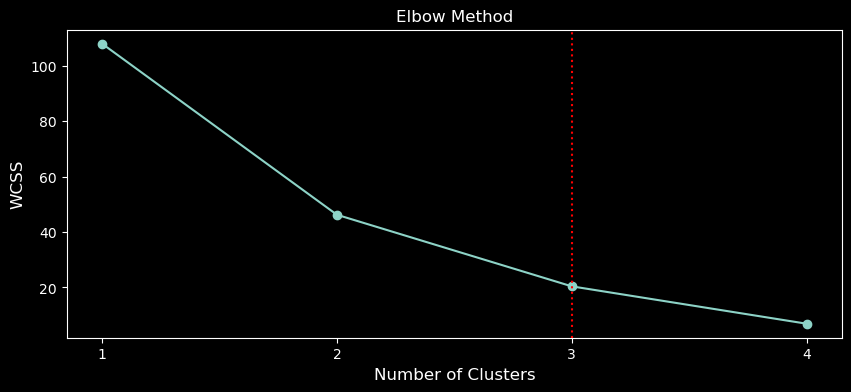

In [8]:
elbow = []
# A stopping point with max no. of clusters admitted is set below... as we have only 5 observations, the max no. of clusters would 
# be 4, 'cause if it were 5, there would be no clusterization at all - each observation would be a cluster on its own, as it 
# happens in a non-clusterized set of observations. So the range of possible clusters' number would be from 1 to (n-1), as below.
# The KMeans algorithm is run for each k number of clusters, and the respective WCSS values are collected (from the inertia_ 
# attribute), and then the graph is plotted. We can see that, starting from 3 clusters, the reduction on the WCSS starts being 
# visually neglectful. That's the elbow point, and, thus, we should choose 3 clusters at our KMeans clustering, for this dataset.
K = range(1,5)
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(entrance_exam_data_without_student)
    elbow.append(kmeanElbow.inertia_)
plt.figure(figsize=(10,4))
plt.plot(K, elbow, marker='o')
plt.xlabel('Number of Clusters', fontsize=12)
plt.xticks(range(1,5))
plt.ylabel('WCSS', fontsize=12)
plt.axvline(x = 3, linestyle = 'dotted', color = 'red')
plt.title('Elbow Method', fontsize=12)
plt.show()

In [9]:
# ANOVA METHOD
# This test is done, for each variable, individually, in order to evaluate how much difference we have between elements at 
# different cluster groups when compared to elements within the same cluster groups. In other words, if the mean of the 
# observations' values for that variable inside any of the clusters is statistically different from the mean of the 
# corresponding values, for the same variable, at other clusters. A third way to view, is how much contribution that variable
# confer to the dataset in order to justify the formation of at least one cluster, with some elements separated from others,
# because of the values (mean) of that variable. This analysis is done for each variable, individually. More than one variable 
# may contribute to the formation of the clusters. For such a variable, if the p-value (p-unc) is statistically significant, 
# that is, if it is less than the standard 0.05 (5%) significance value (> 95% confidance), it means that the contribution of 
# such a variable to the formation of at least one cluster is statistically significant... the higher the F value for that 
# variable, the higher the contribution of that variable to the formation of least one cluster.

# At the current example, according to the statistics below, only when considering the Physics variable the clustering with these
# 3 clusters would make sense, which is influenced by the small size of the sample.

# CLUSTER_INDICATOR_KMEANS MS: indicates the variability between groups
# Within MS: indicates the variability within the groups
# F: test statistic (CLUSTER_INDICATOR_KMEANS MS / Within MS)
# p-unc: p-value of the F statistic
# If p-value < 0.05: at least one cluster has a mean statistically different from the others

In [10]:
# Anova for the Math variable
pg.anova(dv='MATH', between='CLUSTER_INDICATOR_KMEANS', data=entrance_exam_data, detailed=True).T

,0,1
Source,CLUSTER_INDICATOR_KMEANS,Within
SS,16.592,7.98
DF,2,2
MS,8.296,3.99
F,2.079198,NaN
p-unc,0.32476,NaN
np2,0.67524,NaN


In [11]:
# Anova for the Physics variable
pg.anova(dv='PHYSICS', between='CLUSTER_INDICATOR_KMEANS', data=entrance_exam_data, detailed=True).T

,0,1
Source,CLUSTER_INDICATOR_KMEANS,Within
SS,32.612,1.46
DF,2,2
MS,16.306,0.73
F,22.336986,NaN
p-unc,0.04285,NaN
np2,0.95715,NaN


In [12]:
# Anova for the Chemistry variable
pg.anova(dv='CHEMISTRY', between='CLUSTER_INDICATOR_KMEANS', data=entrance_exam_data, detailed=True).T

,0,1
Source,CLUSTER_INDICATOR_KMEANS,Within
SS,38.352,10.94
DF,2,2
MS,19.176,5.47
F,3.505667,NaN
p-unc,0.221943,NaN
np2,0.778057,NaN


In [13]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=entrance_exam_data["MATH"],
    y=entrance_exam_data["CHEMISTRY"],
    z=entrance_exam_data["PHYSICS"],
    mode='markers+text',
    text=entrance_exam_data["STUDENT"],
    textposition='top center',
    textfont=dict(size=10),
    name="Students",
    marker=dict(
        size=4,
        color=entrance_exam_data["CLUSTER_INDICATOR_KMEANS"],
        colorscale='Rainbow',
        showscale=False
    )
))

fig.update_layout(
    title=dict(
        text="Students' Grades - K-Means Clustering - Final",
        subtitle=dict(
            text="(3D Space: Math x Chemistry x Physics)",
            font=dict(size=11)
        ),
        x=0.5,
        xanchor='center',
        font=dict(size=14),
        pad=dict(t=0, b=0)
    ),
    legend=dict(
        itemsizing='constant',
        font=dict(size=11),
    ),
    scene=dict(
        xaxis=dict(title=dict(text="MATH",font=dict(size=10)),tickfont=dict(size=9)),
        yaxis=dict(title=dict(text="CHEMISTRY",font=dict(size=10)),tickfont=dict(size=9)),
        zaxis=dict(title=dict(text="PHYSICS",font=dict(size=10)),tickfont=dict(size=9))
    ),
    width=600,
    height=500,
    margin=dict(
        l=80,
        r=80,
        t=90,
        b=50
    )
)

fig.write_html('./entrance_exam_data_final.html')
fig.show()